In [1]:
pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-m0uwnptq
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-m0uwnptq
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 223e576e2ecb27aaf4f55c6962136a41da755014
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from chronos import ChronosPipeline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch


In [4]:
pipeline = ChronosPipeline.from_pretrained('amazon/chronos-t5-small', device_map='cuda', torch_dtype=torch.bfloat16)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
df = pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/PSMT?period1=1653696000&period2=1716907046&interval=1d&events=history&includeAdjustedClose=true')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-05-31,78.379997,78.680000,77.370003,78.629997,75.616493,218700
1,2022-06-01,78.970001,79.470001,76.750000,77.489998,74.520172,82200
2,2022-06-02,77.669998,79.349998,76.959999,79.209999,76.174263,76500
3,2022-06-03,78.559998,79.199997,78.099998,78.230003,75.231827,69900
4,2022-06-06,78.709999,78.709999,76.239998,77.449997,74.481720,108300
...,...,...,...,...,...,...,...
496,2024-05-21,85.599998,86.029999,84.639999,85.519997,85.519997,94300
497,2024-05-22,85.050003,85.500000,83.830002,84.570000,84.570000,139300
498,2024-05-23,84.570000,84.570000,82.809998,83.180000,83.180000,114800
499,2024-05-24,83.239998,83.910004,82.690002,83.800003,83.800003,170200


In [6]:
ts = df[['Date', 'Close']]

In [7]:
ts['Date'] = pd.to_datetime(ts['Date'])

<ipython-input-7-aed304f7b699>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['Date'] = pd.to_datetime(ts['Date'])


In [8]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    501 non-null    datetime64[ns]
 1   Close   501 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.0 KB


In [9]:
context = torch.tensor(ts['Close'])
prediction_length = 60
forecast = pipeline.predict(context, prediction_length)

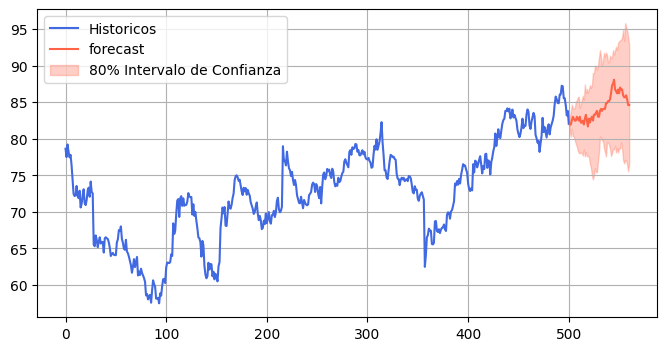

In [10]:
# visualizar el forecast
forecast_index = range(len(ts), len(ts) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(8, 4))
plt.plot(ts['Close'], color="royalblue", label="Historicos")
plt.plot(forecast_index, median, color="tomato", label="forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% Intervalo de Confianza")
plt.legend()
plt.grid()
plt.show()

In [11]:
forecast_index

range(501, 561)

In [12]:
forecast.shape

torch.Size([1, 20, 60])

In [13]:
close_forecast_df = pd.DataFrame()
close_forecast_df['low'] = low
close_forecast_df['forecast'] = median
close_forecast_df['high'] = high
close_forecast_df

,low,forecast,high
0,80.876446,81.940609,83.057980
1,80.291157,81.940609,83.590061
2,81.302111,82.472690,84.654224
3,80.344365,83.004772,84.175351
4,80.291157,82.738731,84.122143
5,79.812283,82.472690,84.175351
6,79.280202,82.472690,85.133097
7,78.960952,83.004772,85.186306
8,78.375663,82.738731,85.665187
9,78.056415,82.472690,85.718395


<Axes: >

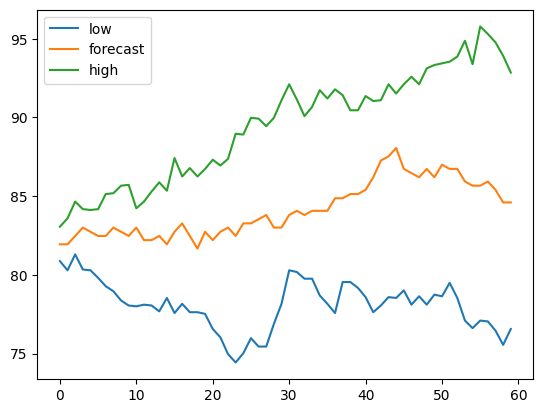

In [14]:
close_forecast_df.plot()

In [16]:
close_forecast_df['Date'] = pd.date_range(start='2024-05-29', periods=len(close_forecast_df), freq='B')

In [17]:
close_forecast_df

,low,forecast,high,Date
0,80.876446,81.940609,83.057980,2024-05-29
1,80.291157,81.940609,83.590061,2024-05-30
2,81.302111,82.472690,84.654224,2024-05-31
3,80.344365,83.004772,84.175351,2024-06-03
4,80.291157,82.738731,84.122143,2024-06-04
5,79.812283,82.472690,84.175351,2024-06-05
6,79.280202,82.472690,85.133097,2024-06-06
7,78.960952,83.004772,85.186306,2024-06-07
8,78.375663,82.738731,85.665187,2024-06-10
9,78.056415,82.472690,85.718395,2024-06-11
